# Person of Interest (POI) Classifier for Enron Data

Qingyu Li

## 1. Project Overview

In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, there was a significant amount of typically confidential information entered into public record, including tens of thousands of emails and detailed financial data for top executives. In this project, we will find features that provide useful information and build a person of interest identifier. We will test the accuracy of prediction of our classifier and find the best predicting model.

## 2. Data Preparation

In [1]:
import sys
import pickle
import numpy
import pandas
import matplotlib

from ggplot import *

sys.path.append("../tools/")

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from feature_format import featureFormat, targetFeatureSplit



In [2]:
### Load the dictionary containing the dataset
enron_data = pickle.load(open("final_project_dataset.pkl", "r") )
## Load POI names file
poi = open("poi_names.txt", "r")

How many people are in the dataset?

In [3]:
len(enron_data.keys())

146

How many features are in the dataset?

In [4]:
len(enron_data.values()[0])

21

From the above, we can see that there are 146 people in this dataset and 21 features in total. Next we print out an example of the data point for better understanding.

In [26]:
enron_data[enron_data.keys()[0]]

{'bonus': 600000,
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'mark.metts@enron.com',
 'exercised_stock_options': 'NaN',
 'expenses': 94299,
 'from_messages': 29,
 'from_poi_to_this_person': 38,
 'from_this_person_to_poi': 1,
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 1740,
 'poi': False,
 'restricted_stock': 585062,
 'restricted_stock_deferred': 'NaN',
 'salary': 365788,
 'shared_receipt_with_poi': 702,
 'to_messages': 807,
 'total_payments': 1061827,
 'total_stock_value': 585062}

- financial features: ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees'] (all units are in US dollars)

- email features: ['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi'] (units are generally number of emails messages; notable exception is ‘email_address’, which is a text string)

- POI label: [‘poi’] (boolean, represented as integer)

Convert data into data frame:

In [3]:
df=pandas.DataFrame.from_records(list(enron_data.values()))
print df.head()


     bonus deferral_payments deferred_income director_fees  \
0   600000               NaN             NaN           NaN   
1  1200000           1295738        -1386055           NaN   
2   350000               NaN         -400729           NaN   
3      NaN               NaN             NaN           NaN   
4  1500000               NaN        -3117011           NaN   

              email_address exercised_stock_options expenses from_messages  \
0      mark.metts@enron.com                     NaN    94299            29   
1                       NaN                 6680544    11200           NaN   
2  steven.elliott@enron.com                 4890344    78552           NaN   
3     bill.cordes@enron.com                  651850      NaN            12   
4    kevin.hannon@enron.com                 5538001    34039            32   

  from_poi_to_this_person from_this_person_to_poi        ...         \
0                      38                       1        ...          
1               

We can see that the missing value are coded as 'NaN'. Next we will need to deal with the 'NaN' and outliers.

### 2.1 Missing Values

In [4]:
df.replace(to_replace='NaN', value=numpy.nan, inplace=True)
df.isnull().sum()

bonus                         64
deferral_payments            107
deferred_income               97
director_fees                129
email_address                 35
exercised_stock_options       44
expenses                      51
from_messages                 60
from_poi_to_this_person       60
from_this_person_to_poi       60
loan_advances                142
long_term_incentive           80
other                         53
poi                            0
restricted_stock              36
restricted_stock_deferred    128
salary                        51
shared_receipt_with_poi       60
to_messages                   60
total_payments                21
total_stock_value             20
dtype: int64

The above table prints out the number of NaNs for each features. We can see that the most missing values is in the loan advances variable. In dealing with the missing data, I decided to remove the variables that have more than 73 missing variables. The reasoning is that since there are 146 people in the dataset, if a variable has more than half of the data points missing, it cannot provide enough information for training classifiers. Then we will remove that variable. For variables that have less missing values, we will use imputation using the median of that variable.

In [5]:
import sklearn
# Removing column from database if counter > 73
for column, series in df.iteritems():
    if series.isnull().sum() > 73:
        df.drop(column, axis=1, inplace=True)
# Drop email address column
if 'email_address' in list(df.columns.values):
    df.drop('email_address', axis=1, inplace=True)

impute = sklearn.preprocessing.Imputer(missing_values=numpy.nan, strategy='median', axis=0)
impute.fit(df)
df_imputed = pandas.DataFrame(impute.transform(df.copy(deep=True)))
df_imputed.columns = list(df.columns.values)

In [8]:
print df_imputed.head()

       bonus  exercised_stock_options  expenses  from_messages  \
0   600000.0                1310813.5   94299.0           29.0   
1  1200000.0                6680544.0   11200.0           41.0   
2   350000.0                4890344.0   78552.0           41.0   
3   769375.0                 651850.0   46950.0           12.0   
4  1500000.0                5538001.0   34039.0           32.0   

   from_poi_to_this_person  from_this_person_to_poi      other  poi  \
0                     38.0                      1.0     1740.0  0.0   
1                     35.0                      8.0  2660303.0  0.0   
2                     35.0                      8.0    12961.0  0.0   
3                     10.0                      0.0    52382.0  0.0   
4                     32.0                     21.0    11350.0  1.0   

   restricted_stock    salary  shared_receipt_with_poi  to_messages  \
0          585062.0  365788.0                    702.0        807.0   
1         3942714.0  267102.0     

I decided to impute using median value since there are some extreme values that skewed the distribution. Therefore, median is more appropriate.

### 2.2 Outliers

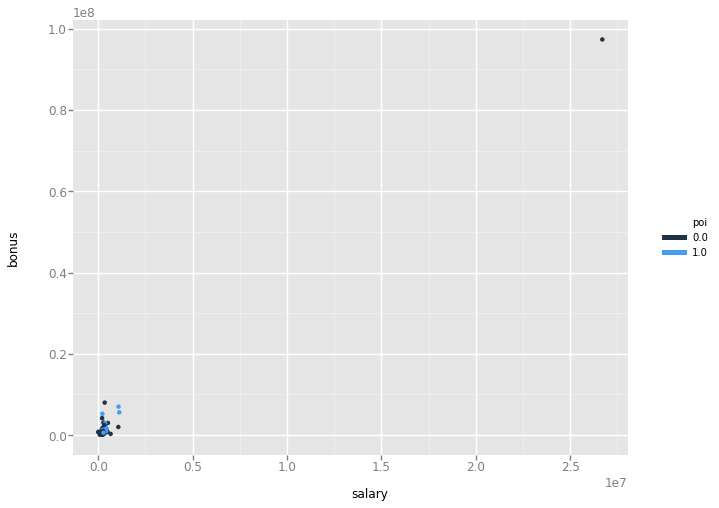

<ggplot: (17063993)>

In [25]:
ggplot(aes(x='salary',y='bonus',color='poi'),data=df_imputed)+geom_point()

From the above plot, we can see that there is a outlier with salary more than $2.5 million. Since this person is not a POI, we are safe to remove this point.

In [6]:
df_cleaned=df_imputed.loc[df_imputed.salary<2500000]

We plot the scatterplot by salary and bonus again:

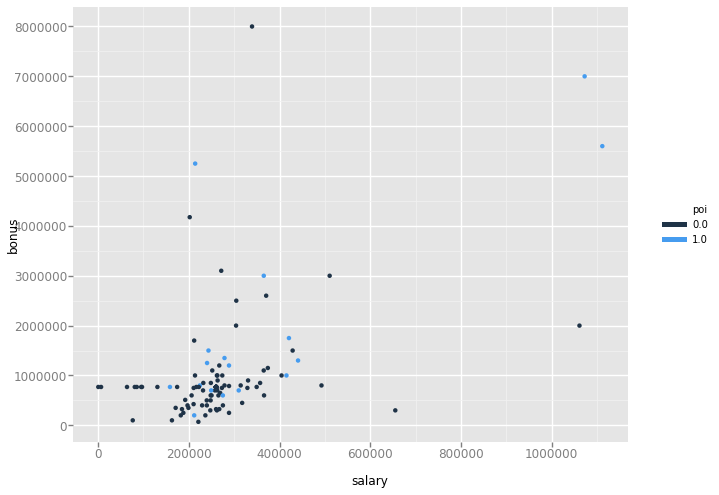

<ggplot: (17038358)>

In [27]:
ggplot(aes(x='salary',y='bonus',color='poi'),data=df_cleaned)+geom_point()

### 2.3 Creating new features

In this section, we will create some new features, calculate ratios that maybe more useful than counts. We noticed that there are variables that counts email interactions between a person with the person of interest(i.e. from_this_person_to_poi and from_poi_to_this_person). It would be interesting to see if there is any difference between POI and non-POI person's email interactions .

We calculate variable POI_email_ratio as the total email interaction with POI by the total email of the person.

In [7]:
df_cleaned['poi_email_ratio']=(df_cleaned['from_poi_to_this_person']+df_cleaned['from_this_person_to_poi'])/(df_cleaned['from_messages']+df_cleaned['to_messages']+1)

C:\Users\kli\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


## 3. Feature Selection

First, we use all data for variable selection. Prepare the data by separating features and labels and rescale the features so that all variables are on the same sacle.

In [10]:
from sklearn import preprocessing
labels = df_cleaned['poi'].astype(int).as_matrix()
features = df_cleaned.drop('poi',1).as_matrix()

min_max_scaler = preprocessing.MinMaxScaler()
features_scaled=min_max_scaler.fit_transform(features)

print features_scaled

[[ 0.0668348   0.03807031  0.41183212 ...,  0.01025186  0.01279963
   0.20792133]
 [ 0.14249685  0.19441665  0.04834328 ...,  0.05440531  0.21701823
   0.15313599]
 [ 0.03530895  0.14229276  0.34295212 ...,  0.00204304  0.13677024
   0.15313599]
 ..., 
 [ 0.0668348   0.09253038  0.20471973 ...,  0.01054962  0.07708687  0.        ]
 [ 0.09205549  0.02220506  0.42044485 ...,  0.00845515  0.02288882  1.        ]
 [ 0.0668348   0.01110618  0.55040133 ...,  0.01228409  0.01673589
   0.29080233]]


In [14]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=1000,random_state=456)
clf.fit(features,labels)
clf.feature_importances_

array([ 0.10029796,  0.09611419,  0.07485434,  0.04247767,  0.05076802,
        0.05502378,  0.06904366,  0.07516882,  0.07303206,  0.08139135,
        0.04424272,  0.06769651,  0.09766499,  0.07222393])

In [15]:
important_features = []
for x,i in enumerate(clf.feature_importances_):
    if i>numpy.average(clf.feature_importances_):
        important_features.append((x))

print important_features

[0, 1, 2, 7, 8, 9, 12, 13]


From the above code, we print out the features that has importance higher than average of all importance calculated before. The output prints out the column number as they are feeded into the classifier. Refer to the feature list we have before, the feature that are contributing important information to the classifier is  Bonus, Exercised Stock Options, Expenses, Salary, Restricted Stocks, Total Stock Value, and POI Email Ratio. 

Next, we split the data into training and testing datasets and use the features we selected to train classifiers. Using training and testing datasets, or cross validation, is a method that is used to assess the performance of a classifier. We will use training set to fit the classifier and test the performance on testing dataset.

In [16]:
from sklearn.model_selection import train_test_split
features_selected=features[:,important_features]
features_train, features_test, labels_train, labels_test = train_test_split(features_selected,labels,test_size=0.3,random_state=123)

### 3.1 Gaussian Naive Bayes

In [72]:
from sklearn.naive_bayes import GaussianNB
clf= GaussianNB()
clf.fit(features_train,labels_train)
pred=clf.predict(features_test)

accuracy = accuracy_score(pred,labels_test)
print "The accuracy score of this classifier is: %s" % accuracy


The accuracy score of this classifier is: 0.886363636364


### 3.2 Random Forest

In [73]:
clf=RandomForestClassifier()
clf.fit(features_train,labels_train)
pred=clf.predict(features_test)
accuracy = accuracy_score(pred,labels_test)
print "The accuracy score of this classifier is: %s" % accuracy

The accuracy score of this classifier is: 0.840909090909


### 3.3 Adaboost Classifier

In [27]:
from sklearn.ensemble import AdaBoostClassifier
clf=AdaBoostClassifier()
clf.fit(features_train,labels_train)
pred=clf.predict(features_test)
accuracy = accuracy_score(pred,labels_test)
print "The accuracy score of this classifier is: %s" % accuracy

The accuracy score of this classifier is: 0.863636363636


### 3.4 Logistic Regression

In [30]:
from sklearn.linear_model import LogisticRegression
clf=LogisticRegression()
clf.fit(features_train,labels_train)
pred=clf.predict(features_test)
accuracy = accuracy_score(pred,labels_test)
print "The accuracy score of this classifier is: %s" % accuracy

The accuracy score of this classifier is: 0.795454545455


## 4. Tuning Classifier

From previous section, we can see that Naive Bayes provides the best prediction accuracy. The next best classifier is Adaboost Classifier. The accuracy for Random Forest and Logistic Regression is the lowest two. Next, we will tune these classifiers and see if we can improve the models.

Next we will tune the classifiers to improve the prediction accuracy.

### 4.1 Naive Bayes

In [96]:
clf= GaussianNB()
clf.fit(features_train,labels_train)
pred=clf.predict(features_test)

accuracy = accuracy_score(pred,labels_test)
recall=recall_score(labels_test,pred)
precision=precision_score(labels_test,pred)
print "The accuracy score of this classifier is: %s" % accuracy
print "The recall score of this classifier is: %s" % recall
print "The precision score of this classifier is: %s" % precision

The accuracy score of this classifier is: 0.886363636364
The recall score of this classifier is: 0.428571428571
The precision score of this classifier is: 0.75


Naive Bayes don't have a lot of parameters available for tuning. The precision of the prediction is 0.75 while recall rate is 0.4285. 

### 4.2 Random Forest

In [25]:
clf=RandomForestClassifier(n_estimators=30,min_samples_split=10,max_features=8)
clf.fit(features_train,labels_train)
pred=clf.predict(features_test)

accuracy = accuracy_score(pred,labels_test)
recall=recall_score(labels_test,pred)
precision=precision_score(labels_test,pred)
print "The accuracy score of this classifier is: %s" % accuracy
print "The recall score of this classifier is: %s" % recall
print "The precision score of this classifier is: %s" % precision

The accuracy score of this classifier is: 0.909090909091
The recall score of this classifier is: 0.428571428571
The precision score of this classifier is: 1.0


The precision score is 1 and recall score is 0.4286. We have a high precision score and a relatively low recall score. This indicates that the classifier returns most of the predicted testing labels correctly. The random forest classifier is very good in labeling a true POI person as a POI.

### 4.3 AdaBoost

In [28]:
clf=AdaBoostClassifier(n_estimators=10,learning_rate=1.5,algorithm='SAMME')
clf.fit(features_train,labels_train)
pred=clf.predict(features_test)
accuracy = accuracy_score(pred,labels_test)
recall=recall_score(labels_test,pred)
precision=precision_score(labels_test,pred)
print "The accuracy score of this classifier is: %s" % accuracy
print "The recall score of this classifier is: %s" % recall
print "The precision score of this classifier is: %s" % precision

The accuracy score of this classifier is: 0.886363636364
The recall score of this classifier is: 0.428571428571
The precision score of this classifier is: 0.75


We tuned Adaboost classifier using n_estimators, learning_rate and algorithm. After tuning, the accuracy score increased about 2%. This classifier has the same precision and recall rate as that of Naive Bayes.

### 4.4 Logistic Regression

In [35]:
clf=LogisticRegression(penalty='l1' )
clf.fit(features_train,labels_train)
pred=clf.predict(features_test)

accuracy = accuracy_score(pred,labels_test)
recall=recall_score(labels_test,pred)
precision=precision_score(labels_test,pred)
print "The accuracy score of this classifier is: %s" % accuracy
print "The recall score of this classifier is: %s" % recall
print "The precision score of this classifier is: %s" % precision

The accuracy score of this classifier is: 0.840909090909
The recall score of this classifier is: 0.142857142857
The precision score of this classifier is: 0.5


In the code, the penalty method is changed into L1 regularization. This changed increased the accuracy score by 4%.

The precision score is 0.5 and recall score is 0.1428. This indicates that the classifier returns some of the predicted labels correctly. Compared to random forest, the logistic regression classifier is not as good as the performance of random forest.

Comparing the four classifier trained and tuned so far, I believe random forest is the best classifier that has the highest precision rate and accuracy score.

## 5. Summary and Conclusion

In this project, we cleaned and studied the Enron dataset to build classifiers to identify if a person would be person of interest (POI) using financial features and email interactions between people. We first cleaned and impute the missing values and then calculated some ratios that would be useful in building classifiers. And next we built several classifiers using the training data and test the prediction power using test data. 

In the last section, we tuned the classifiers and tried to improve their predicting accuracy. Comparing the performance of all four classifiers, random forest classifier has the highes accuracy and precision rate and should be selected as the final analysis classifier.

## 6. Reference

sklearn help pages



http://stackoverflow.com/questions/22361781/how-does-sklearn-random-forest-index-feature-importances

https://stats.stackexchange.com/questions/58214/when-does-naive-bayes-perform-better-than-svm

http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

http://optunity.readthedocs.io/en/latest/notebooks/notebooks/sklearn-automated-classification.html
